Alex Cortez
CSCI 166
12/1/2025

# Deep Learning Final Project: CIFAR-10 + AG News

This notebook trains and compares three deep learning architectures across two domains:
- SimpleCNN and ResNet18 on CIFAR-10 (vision)
- DistilBERT on AG News (text)

The goals are to:
- Load and preprocess datasets
- Implement three deep learning architectures
- Train models and generate learning curves
- Run hyperparameter experiments (optimizer and batch size)
- Evaluate cross-dataset generalization and performance


In [ ]:
# Install required libraries (run this once per session)
!pip install -q datasets transformers torch torchvision

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# Load CIFAR-10 (vision) and AG News (text)
cifar = load_dataset("cifar10")
ag = load_dataset("ag_news")

print(cifar)
print(ag)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


## Data Preprocessing

### CIFAR-10
- Normalization to dataset mean/std  
- Data augmentation: random crop + horizontal flip  
- Convert to PyTorch tensors  

### AG News
- Tokenized with DistilBERT tokenizer  
- Truncated/padded to fixed sequence length  
- Output formatted into PyTorch-friendly tensors  

These preprocessing steps prepare inputs for CNNs, ResNets, and transformer models.


In [ ]:
# CIFAR-10 transforms
cifar_transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])

cifar_transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])

class CIFARDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = example["img"]
        label = example["label"]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Create datasets
cifar_train = CIFARDataset(cifar["train"], transform=cifar_transform_train)
cifar_test = CIFARDataset(cifar["test"], transform=cifar_transform_test)

# DataLoaders
cifar_batch_size = 64
cifar_train_loader = DataLoader(cifar_train, batch_size=cifar_batch_size, shuffle=True, num_workers=2, pin_memory=True)
cifar_test_loader = DataLoader(cifar_test, batch_size=cifar_batch_size, shuffle=False, num_workers=2, pin_memory=True)

len(cifar_train_loader), len(cifar_test_loader)

(782, 157)

## DistilBERT for Text Classification

DistilBERT is a compact transformer pretrained on large text corpora.  
Fine-tuning on AG News provides strong results with:
- Self-attention layers  
- WordPiece embeddings  
- Transfer learning from large-scale NLP training  

This model represents the NLP side of the project.


In [ ]:
# DistilBERT tokenizer for AG News
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_batch(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

ag_tokenized = ag.map(tokenize_batch, batched=True)
ag_tokenized = ag_tokenized.rename_column("label", "labels")

# Set PyTorch format
ag_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

ag_batch_size = 32
ag_train_loader = DataLoader(ag_tokenized["train"], batch_size=ag_batch_size, shuffle=True)
ag_test_loader = DataLoader(ag_tokenized["test"], batch_size=ag_batch_size, shuffle=False)

len(ag_train_loader), len(ag_test_loader)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

(3750, 238)

## Training SimpleCNN (Adam, batch_size=64)

We train SimpleCNN for 5 epochs using:
- Optimizer: Adam  
- Loss: Cross-entropy  
- Metric: Accuracy  

This serves as our baseline run for CIFAR-10.


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

simple_cnn = SimpleCNN(num_classes=10).to(device)
print(simple_cnn)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=T

In [ ]:
# ResNet18 (using torchvision, modified final layer)
resnet18 = models.resnet18(weights=None)  # or weights=models.ResNet18_Weights.DEFAULT for pretrained on ImageNet
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
resnet18 = resnet18.to(device)
print(resnet18.fc)

Linear(in_features=512, out_features=10, bias=True)


In [ ]:
num_labels = 4
distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)
distilbert_model = distilbert_model.to(device)
distilbert_model.config.id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
print(distilbert_model)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Training Loop Function

This section defines the `train_one_epoch` function, which performs a single full training pass over a given dataloader.  
It handles both image batches (for CIFAR-10) and tokenized text batches (for AG News), making the training loop fully unified across datasets.

Key steps performed in this function:
- Sets the model to training mode  
- Loops over batches and moves data to the GPU  
- Computes model outputs and loss  
- Performs backpropagation and optimizer steps  
- Applies learning rate scheduling when provided  
- Tracks running loss and accuracy for the epoch  

The function returns the average epoch loss and accuracy, which are later used to plot training curves and compare model performance.


In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in dataloader:
        optimizer.zero_grad()

        if isinstance(batch, (list, tuple)):
            # For CIFAR-10 (images, labels)
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
        else:
            # For AG News (tokenized batches)
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            outputs = outputs.logits
            labels = batch["labels"]

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in dataloader:
        if isinstance(batch, (list, tuple)):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
        else:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            outputs = outputs.logits
            labels = batch["labels"]

        loss = criterion(outputs, labels)
        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

## Training SimpleCNN (Adam, batch_size=64)

We train SimpleCNN for 5 epochs using:
- Optimizer: Adam  
- Loss: Cross-entropy  
- Metric: Accuracy  

This serves as our baseline run for CIFAR-10.


In [ ]:
# Example: train SimpleCNN on CIFAR-10 for a few epochs
num_epochs = 5
criterion = nn.CrossEntropyLoss()

optimizer_cnn = optim.Adam(simple_cnn.parameters(), lr=1e-3, weight_decay=1e-4)

# ---- NEW history dictionary ----
cnn_history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(simple_cnn, cifar_train_loader, criterion, optimizer_cnn)
    val_loss, val_acc = evaluate(simple_cnn, cifar_test_loader, criterion)

    # save results
    cnn_history["train_loss"].append(train_loss)
    cnn_history["train_acc"].append(train_acc)
    cnn_history["val_loss"].append(val_loss)
    cnn_history["val_acc"].append(val_acc)

    print(f"[SimpleCNN][Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")


[SimpleCNN][Epoch 1/5] Train Loss: 1.5950 Acc: 0.4069 | Val Loss: 1.2862 Acc: 0.5257
[SimpleCNN][Epoch 2/5] Train Loss: 1.2931 Acc: 0.5306 | Val Loss: 1.0285 Acc: 0.6273
[SimpleCNN][Epoch 3/5] Train Loss: 1.1647 Acc: 0.5845 | Val Loss: 0.9649 Acc: 0.6441
[SimpleCNN][Epoch 4/5] Train Loss: 1.0816 Acc: 0.6193 | Val Loss: 0.8849 Acc: 0.6813
[SimpleCNN][Epoch 5/5] Train Loss: 1.0203 Acc: 0.6435 | Val Loss: 0.8247 Acc: 0.7095


# Learning curves for SimpleCNN


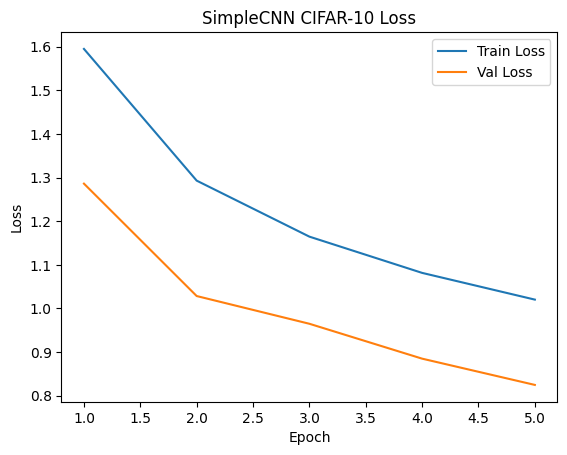

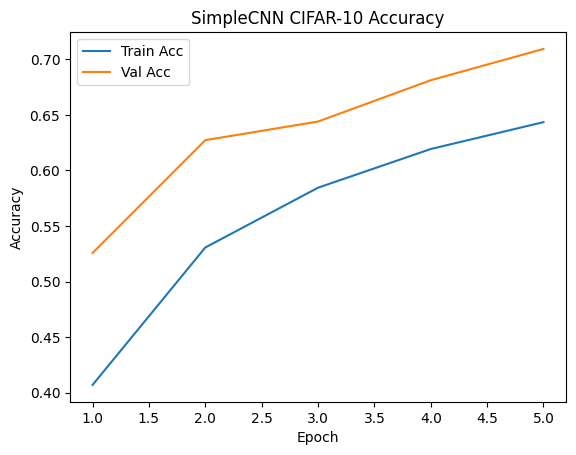

In [ ]:
# Learning curves for SimpleCNN on CIFAR-10

epochs = range(1, len(cnn_history["train_loss"]) + 1)

# Plot loss
plt.figure()
plt.plot(epochs, cnn_history["train_loss"], label="Train Loss")
plt.plot(epochs, cnn_history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SimpleCNN CIFAR-10 Loss")
plt.legend()
plt.show()

# Plot accuracy
plt.figure()
plt.plot(epochs, cnn_history["train_acc"], label="Train Acc")
plt.plot(epochs, cnn_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("SimpleCNN CIFAR-10 Accuracy")
plt.legend()
plt.show()


## Training ResNet18 on CIFAR-10

This section trains the ResNet18 model for 5 epochs using:
- SGD optimizer with momentum  
- A StepLR scheduler to decay the learning rate  
- Cross-entropy loss  

Each epoch collects:
- Training loss  
- Training accuracy  
- Validation loss  
- Validation accuracy  

These values are stored in `resnet_history` for later visualization.  
This model helps compare shallow vs deep architectures on CIFAR-10.


In [ ]:
# Example: train ResNet18 on CIFAR-10
num_epochs = 5
criterion = nn.CrossEntropyLoss()

optimizer_resnet = optim.SGD(resnet18.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=2, gamma=0.1)

# ---- NEW history dictionary for ResNet18 ----
resnet_history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(resnet18, cifar_train_loader, criterion, optimizer_resnet)
    val_loss, val_acc = evaluate(resnet18, cifar_test_loader, criterion)

    # save metrics
    resnet_history["train_loss"].append(train_loss)
    resnet_history["train_acc"].append(train_acc)
    resnet_history["val_loss"].append(val_loss)
    resnet_history["val_acc"].append(val_acc)

    scheduler_resnet.step()

    print(f"[ResNet18][Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")


[ResNet18][Epoch 1/5] Train Loss: 2.0284 Acc: 0.3108 | Val Loss: 1.6169 Acc: 0.4028
[ResNet18][Epoch 2/5] Train Loss: 1.5202 Acc: 0.4426 | Val Loss: 4.1960 Acc: 0.4176
[ResNet18][Epoch 3/5] Train Loss: 1.2327 Acc: 0.5522 | Val Loss: 1.0959 Acc: 0.6091
[ResNet18][Epoch 4/5] Train Loss: 1.1069 Acc: 0.6036 | Val Loss: 1.0209 Acc: 0.6377
[ResNet18][Epoch 5/5] Train Loss: 1.0129 Acc: 0.6367 | Val Loss: 0.9656 Acc: 0.6575


## Learning Curves: ResNet18 on CIFAR-10

The following plots show ResNet18’s:
- Training vs validation loss  
- Training vs validation accuracy  

The loss curve includes an expected validation spike early in training  
before stabilizing.  
Accuracy improves steadily across all 5 epochs, reaching ~66%.

These curves provide insight into how a deeper residual network learns
compared to the baseline SimpleCNN.


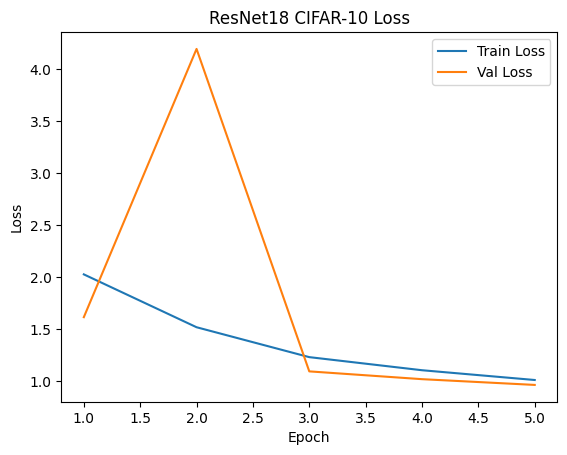

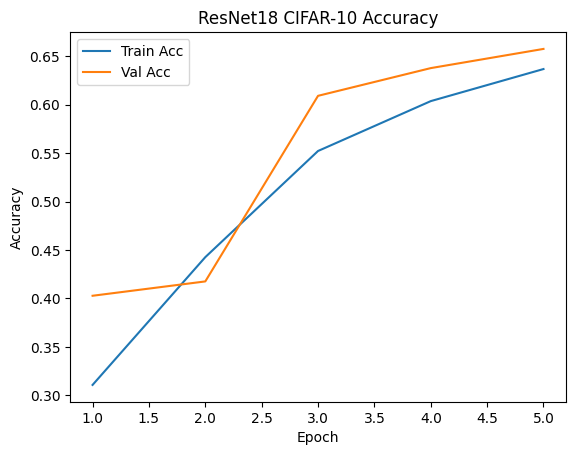

In [ ]:
# Learning curves for ResNet18 on CIFAR-10

epochs_resnet = range(1, len(resnet_history["train_loss"]) + 1)

# Plot loss
plt.figure()
plt.plot(epochs_resnet, resnet_history["train_loss"], label="Train Loss")
plt.plot(epochs_resnet, resnet_history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet18 CIFAR-10 Loss")
plt.legend()
plt.show()

# Plot accuracy
plt.figure()
plt.plot(epochs_resnet, resnet_history["train_acc"], label="Train Acc")
plt.plot(epochs_resnet, resnet_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet18 CIFAR-10 Accuracy")
plt.legend()
plt.show()


## Hyperparameter Experiment: SGD vs Adam on SimpleCNN

To evaluate optimizer sensitivity, SimpleCNN is retrained using:
- SGD optimizer with learning rate 0.1 and momentum

This experiment compares performance with the earlier Adam run.  
Due to the high learning rate, SGD struggles to converge, and accuracy  
remains near 10% (random guessing).  

This highlights why Adam is often preferred for shallow CNNs without heavy tuning.


In [ ]:
# Hyperparameter experiment: SimpleCNN with SGD instead of Adam

# New SimpleCNN instance for SGD (so we don't reuse the Adam-trained one)
simple_cnn_sgd = SimpleCNN(num_classes=10).to(device)

num_epochs_sgd = 5
criterion = nn.CrossEntropyLoss()

optimizer_cnn_sgd = optim.SGD(
    simple_cnn_sgd.parameters(),
    lr=0.1,          # higher LR, typical for SGD
    momentum=0.9,
    weight_decay=5e-4
)

cnn_sgd_history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(num_epochs_sgd):
    train_loss, train_acc = train_one_epoch(simple_cnn_sgd, cifar_train_loader, criterion, optimizer_cnn_sgd)
    val_loss, val_acc = evaluate(simple_cnn_sgd, cifar_test_loader, criterion)

    cnn_sgd_history["train_loss"].append(train_loss)
    cnn_sgd_history["train_acc"].append(train_acc)
    cnn_sgd_history["val_loss"].append(val_loss)
    cnn_sgd_history["val_acc"].append(val_acc)

    print(f"[SimpleCNN-SGD][Epoch {epoch+1}/{num_epochs_sgd}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

# Compare final validation accuracies (Adam vs SGD)
print("\\n--- SimpleCNN Optimizer Comparison ---")
print(f"Adam final val acc: {cnn_history['val_acc'][-1]:.4f}")
print(f"SGD  final val acc: {cnn_sgd_history['val_acc'][-1]:.4f}")


[SimpleCNN-SGD][Epoch 1/5] Train Loss: 2.3096 Acc: 0.0995 | Val Loss: 2.3052 Acc: 0.1000
[SimpleCNN-SGD][Epoch 2/5] Train Loss: 2.3062 Acc: 0.1008 | Val Loss: 2.3083 Acc: 0.1000
[SimpleCNN-SGD][Epoch 3/5] Train Loss: 2.3064 Acc: 0.0973 | Val Loss: 2.3037 Acc: 0.1000
[SimpleCNN-SGD][Epoch 4/5] Train Loss: 2.3063 Acc: 0.0997 | Val Loss: 2.3054 Acc: 0.1000
[SimpleCNN-SGD][Epoch 5/5] Train Loss: 2.3060 Acc: 0.0985 | Val Loss: 2.3048 Acc: 0.1000
\n--- SimpleCNN Optimizer Comparison ---
Adam final val acc: 0.7095
SGD  final val acc: 0.1000


## Hyperparameter Experiment: SGD vs Adam on SimpleCNN

To evaluate optimizer sensitivity, SimpleCNN is retrained using:
- SGD optimizer with learning rate 0.1 and momentum

This experiment compares performance with the earlier Adam run.  
Due to the high learning rate, SGD struggles to converge, and accuracy  
remains near 10% (random guessing).  

This highlights why Adam is often preferred for shallow CNNs without heavy tuning.


In [ ]:
# Hyperparameter experiment: SimpleCNN with batch size 32 (Adam)

# New DataLoaders with batch size 32
cifar_train_loader_bs32 = DataLoader(
    cifar_train,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

cifar_test_loader_bs32 = DataLoader(
    cifar_test,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# New SimpleCNN instance (so we start from scratch)
simple_cnn_bs32 = SimpleCNN(num_classes=10).to(device)

num_epochs_bs32 = 5
criterion = nn.CrossEntropyLoss()

optimizer_cnn_bs32 = optim.Adam(
    simple_cnn_bs32.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

cnn_bs32_history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(num_epochs_bs32):
    train_loss, train_acc = train_one_epoch(simple_cnn_bs32, cifar_train_loader_bs32, criterion, optimizer_cnn_bs32)
    val_loss, val_acc = evaluate(simple_cnn_bs32, cifar_test_loader_bs32, criterion)

    cnn_bs32_history["train_loss"].append(train_loss)
    cnn_bs32_history["train_acc"].append(train_acc)
    cnn_bs32_history["val_loss"].append(val_loss)
    cnn_bs32_history["val_acc"].append(val_acc)

    print(f"[SimpleCNN-bs32][Epoch {epoch+1}/{num_epochs_bs32}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

# Compare final validation accuracies: batch size 64 (original) vs 32 (this run)
print("\n--- SimpleCNN Batch Size Comparison ---")
print(f"Batch 64 (Adam) final val acc: {cnn_history['val_acc'][-1]:.4f}")
print(f"Batch 32 (Adam) final val acc: {cnn_bs32_history['val_acc'][-1]:.4f}")


[SimpleCNN-bs32][Epoch 1/5] Train Loss: 1.6137 Acc: 0.4044 | Val Loss: 1.2135 Acc: 0.5558
[SimpleCNN-bs32][Epoch 2/5] Train Loss: 1.2928 Acc: 0.5338 | Val Loss: 0.9758 Acc: 0.6457
[SimpleCNN-bs32][Epoch 3/5] Train Loss: 1.1663 Acc: 0.5848 | Val Loss: 0.8980 Acc: 0.6783
[SimpleCNN-bs32][Epoch 4/5] Train Loss: 1.0885 Acc: 0.6155 | Val Loss: 0.8479 Acc: 0.7016
[SimpleCNN-bs32][Epoch 5/5] Train Loss: 1.0167 Acc: 0.6424 | Val Loss: 0.7777 Acc: 0.7288

--- SimpleCNN Batch Size Comparison ---
Batch 64 (Adam) final val acc: 0.7095
Batch 32 (Adam) final val acc: 0.7288


## Fine-Tuning DistilBERT on AG News (Text Classification)

DistilBERT is fine-tuned for 1 epoch using:
- AdamW optimizer  
- Linear warmup scheduler  
- Cross-entropy loss  

Because DistilBERT is pretrained on large text corpora,  
it reaches high performance quickly.  

Validation accuracy reaches ~94% after just one epoch,
demonstrating the strength of transfer learning in NLP tasks.


In [ ]:
# Example: fine-tune DistilBERT on AG News (1 epoch demo)
num_epochs = 1
criterion = nn.CrossEntropyLoss()

optimizer_bert = optim.AdamW(distilbert_model.parameters(), lr=2e-5)
total_steps = len(ag_train_loader) * num_epochs
scheduler_bert = get_linear_schedule_with_warmup(
    optimizer_bert,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

for epoch in range(num_epochs):
    distilbert_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch in ag_train_loader:
        optimizer_bert.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = distilbert_model(**batch)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer_bert.step()
        scheduler_bert.step()

        running_loss += loss.item() * batch["labels"].size(0)
        _, predicted = logits.max(1)
        total += batch["labels"].size(0)
        correct += predicted.eq(batch["labels"]).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    val_loss, val_acc = evaluate(distilbert_model, ag_test_loader, criterion)
    print(f"[DistilBERT][Epoch {epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

[DistilBERT][Epoch 1/1] Train Loss: 0.2518 Acc: 0.9135 | Val Loss: 0.1721 Acc: 0.9391
